In [2]:
import os

from scipy.stats import ttest_ind
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pyometiff
import pandas as pd
import seaborn as sns
from google.colab import drive

In [3]:
PATH_TO_FOLDER = os.path.join('..', 'd4l')
TRAIN_DATA_PATH = os.path.join(PATH_TO_FOLDER, 'train')
# ORIGINAL_IMAGE_DATA_SUBDIR = 'images_masks'
# ORIGINAL_MASKS_SUBDIR = 'masks'
# ORIGINAL_IMAGES_SUBDIR = 'img'

drive.mount('/content/drive')
PATH_TO_FOLDER = '/content/drive/My drive/MAGISTERKA/DL'
TRAIN_DATA_PATH = os.path.join(PATH_TO_FOLDER, 'train')


if PATH_TO_FOLDER is None:
    raise ValueError('Please set PATH_TO_FOLDER to a path with unzipped training data.')

ANNDATA_PATH = 'cell_data.h5ad'
TRAIN_ANNDATA_PATH = os.path.join(TRAIN_DATA_PATH, ANNDATA_PATH)
# TRAIN_IMAGE_DATA_DIR = os.path.join(TRAIN_DATA_PATH, ORIGINAL_IMAGE_DATA_SUBDIR)
# TRAIN_IMAGE_DATA_IMAGES = os.path.join(TRAIN_IMAGE_DATA_DIR, ORIGINAL_IMAGES_SUBDIR)
# TRAIN_IMAGE_DATA_MASKS = os.path.join(TRAIN_IMAGE_DATA_DIR, ORIGINAL_MASKS_SUBDIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
PATH_TO_FOLDER = '/content/drive/My Drive/MAGISTERKA/DL'
TRAIN_DATA_PATH = os.path.join(PATH_TO_FOLDER, 'train')


if PATH_TO_FOLDER is None:
    raise ValueError('Please set PATH_TO_FOLDER to a path with unzipped training data.')

ANNDATA_PATH = 'cell_data.h5ad'
TRAIN_ANNDATA_PATH = os.path.join(TRAIN_DATA_PATH, ANNDATA_PATH)
# TRAIN_IMAGE_DATA_DIR = os.path.join(TRAIN_DATA_PATH, ORIGINAL_IMAGE_DATA_SUBDIR)
# TRAIN_IMAGE_DATA_IMAGES = os.path.join(TRAIN_IMAGE_DATA_DIR, ORIGINAL_IMAGES_SUBDIR)
# TRAIN_IMAGE_DATA_MASKS = os.path.join(TRAIN_IMAGE_DATA_DIR, ORIGINAL_MASKS_SUBDIR)

In [5]:
def normalize(expressions, scaling_factor=5):
    """
    Transform in CELESTA.ipynb

    Normalizes expression data using the arcsinh transformation.
    """
    expressions_transformed = np.arcsinh(expressions) / scaling_factor
    return expressions_transformed

def plot_marker_expressions(exp_df, markers):
    fig, axs = plt.subplots(len(markers), 1, figsize=(7, 5 * len(markers)))
    for i, gene in enumerate(markers):
        axs[i].hist(exp_df[gene], bins=100, color='r', alpha=0.5)
        axs[i].set_title(f'{gene} - Raw')
    plt.show()

def plot_cell_type_count(exp_df):
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ax.hist(exp_df['celltypes'], bins=30, color='r', alpha=0.5)
    ax.set_title('Cell Type Count')
    plt.show()

def plot_marker_expression_range(exp_df, markers):
    """
    Plot the range of expression values for each marker gene. Scatter plot of the minimum and maximum expression values.
    """
    fig, axs = plt.subplots(len(markers), 1, figsize=(15, 5 * len(markers)))
    for i, marker in enumerate(markers):
        axs[i].scatter(exp_df['celltypes'], exp_df[marker], color='g', alpha=0.1)
        axs[i].set_title(f'{marker} - Expression Range')
    plt.show()

def plot_variance_of_markers(exp_df):
    """
    Plot the variance of each marker gene.
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.bar(exp_df.columns, exp_df.var(), color='b', alpha=0.5)
    ax.set_title('Variance of Marker Genes')
    ax.set_xticklabels(exp_df.columns, rotation=90)
    plt.show()

def analyze_marker_expressions(exp_df, all_data_df, p_value_threshold=0.01):
    cell_types = all_data_df['celltypes'].unique()
    markers = exp_df.columns
    result = {}
    subjects = all_data_df['sample_id'].unique()


    for cell_type in cell_types:
        lower_markers = []
        higher_markers = []
        for subject in subjects:
            lower = set()
            higher = set()
            subject_df = all_data_df[all_data_df['sample_id'] == subject]
            for marker in markers:
                cell_type_expr = subject_df[subject_df['celltypes'] == cell_type][marker]
                other_cell_types_expr = subject_df[subject_df['celltypes'] != cell_type][marker]

                t_stat, p_value = ttest_ind(cell_type_expr, other_cell_types_expr)
                if p_value < p_value_threshold:
                    if cell_type_expr.mean() < other_cell_types_expr.mean():
                        lower.add(marker)
                    else:
                        higher.add(marker)
            lower_markers.append(lower)
            higher_markers.append(higher)
        result[cell_type] = {'lower': lower_markers, 'higher': higher_markers}

    return result

def get_significant_markers(marker_dict, all_data_df, threshold=0.8):
    """
    Get the markers that are present in cell types in at least 80% of subjects.
    """
    num_of_subjects = len(all_data_df['sample_id'].unique())
    result_dict = {}
    for cell_type, markers_sets in marker_dict.items():
        result_dict[cell_type] = {'lower' : [], 'higher' : []}
        for markers_set in markers_sets['lower']:
            result_dict[cell_type]['lower'] += markers_set
        for markers_set in markers_sets['higher']:
            result_dict[cell_type]['higher'] += markers_set

        result_dict[cell_type]['lower'] = [marker for marker in set(result_dict[cell_type]['lower']) if result_dict[cell_type]['lower'].count(marker) / num_of_subjects >= threshold]
        result_dict[cell_type]['higher'] = [marker for marker in set(result_dict[cell_type]['higher']) if result_dict[cell_type]['higher'].count(marker) / num_of_subjects >= threshold]
    return result_dict

def make_table_with_significant_markers(significant_markers_dict):
    all_markers = set()

    cell_types = significant_markers_dict.keys()
    for cell_type, markers_dict in significant_markers_dict.items():
        all_markers.update(markers_dict['lower'])
        all_markers.update(markers_dict['higher'])
    marker_to_level_dict = {marker: [] for marker in all_markers}
    for cell_type, markers_dict in significant_markers_dict.items():
        for marker in all_markers:
            if marker in markers_dict['lower']:
                marker_to_level_dict[marker].append('lower')
            elif marker in markers_dict['higher']:
                marker_to_level_dict[marker].append('higher')
            else:
                marker_to_level_dict[marker].append('none')

    result_df = pd.DataFrame(marker_to_level_dict)
    result_df['celltype'] = cell_types
    result_df.set_index('celltype', inplace=True)

    return result_df

In [6]:
train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)

In [7]:
markers = train_anndata.var['marker']
expressions_df = pd.DataFrame(train_anndata.layers["exprs"], columns=markers)
all_data = pd.concat([train_anndata.obs.reset_index(), expressions_df], axis=1)

In [8]:
print("There is a total of", len(all_data), "cells in the dataset.")

There is a total of 236791 cells in the dataset.


In [9]:
print("Minimal expression value: ", np.min(expressions_df.values))
print("Maximal expression value: ", np.max(expressions_df.values))
print("Mean expression value: ", np.mean(expressions_df.values))
print("Median expression value: ", np.median(expressions_df.values))
print("Maximal standard deviation of expression values: ", np.max(np.std(expressions_df.values, axis=0)))
print("Minimal standard deviation of expression values: ", np.min(np.std(expressions_df.values, axis=0)))

Minimal expression value:  0.0
Maximal expression value:  8.436070526198012
Mean expression value:  1.347737665027196
Median expression value:  0.914181447627153
Maximal standard deviation of expression values:  1.4945013816311672
Minimal standard deviation of expression values:  0.28289971656300267


There are only non-negative marker expression values.

The 'distToCells' column is the only one containing NaN values, with a total of 11829 NaN entries.

In [10]:
all_data['distToCells'].isnull().sum()

11829

# General data overview

The dataset provided includes spatial information at the individual cell level. It includes X and Y coordinates, along with marker levels acquired through the IMC method, as well as cell types.

In [11]:
print(f"Dataset has {len(all_data['image'].unique())} tissue images from {len(all_data['sample_id'].unique())} unique subjects.")
print(f"Dataset has {len(all_data['celltypes'].unique())} unique cell types:", ", ".join(list(all_data['celltypes'].unique())))
print(f"Each cell has {len(expressions_df.columns)} features (marker expressions):", ", ".join(list(expressions_df.columns)))

Dataset has 125 tissue images from 125 unique subjects.
Dataset has 15 unique cell types: MacCD163, Mural, DC, Tumor, CD4, HLADR, NK, CD8, Treg, Neutrophil, plasma, undefined, B, pDC, BnT
Each cell has 40 features (marker expressions): MPO, HistoneH3, SMA, CD16, CD38, HLADR, CD27, CD15, CD45RA, CD163, B2M, CD20, CD68, Ido1, CD3, LAG3, CD11c, PD1, PDGFRb, CD7, GrzB, PDL1, TCF7, CD45RO, FOXP3, ICOS, CD8a, CarbonicAnhydrase, CD33, Ki67, VISTA, CD40, CD4, CD14, Ecad, CD303, CD206, cleavedPARP, DNA1, DNA2


In [12]:
expressions_df.columns

Index(['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
       'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
       'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
       'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
       'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
       'DNA2'],
      dtype='object', name='marker')


Below we present distribution of normalized data for a couple of markers.

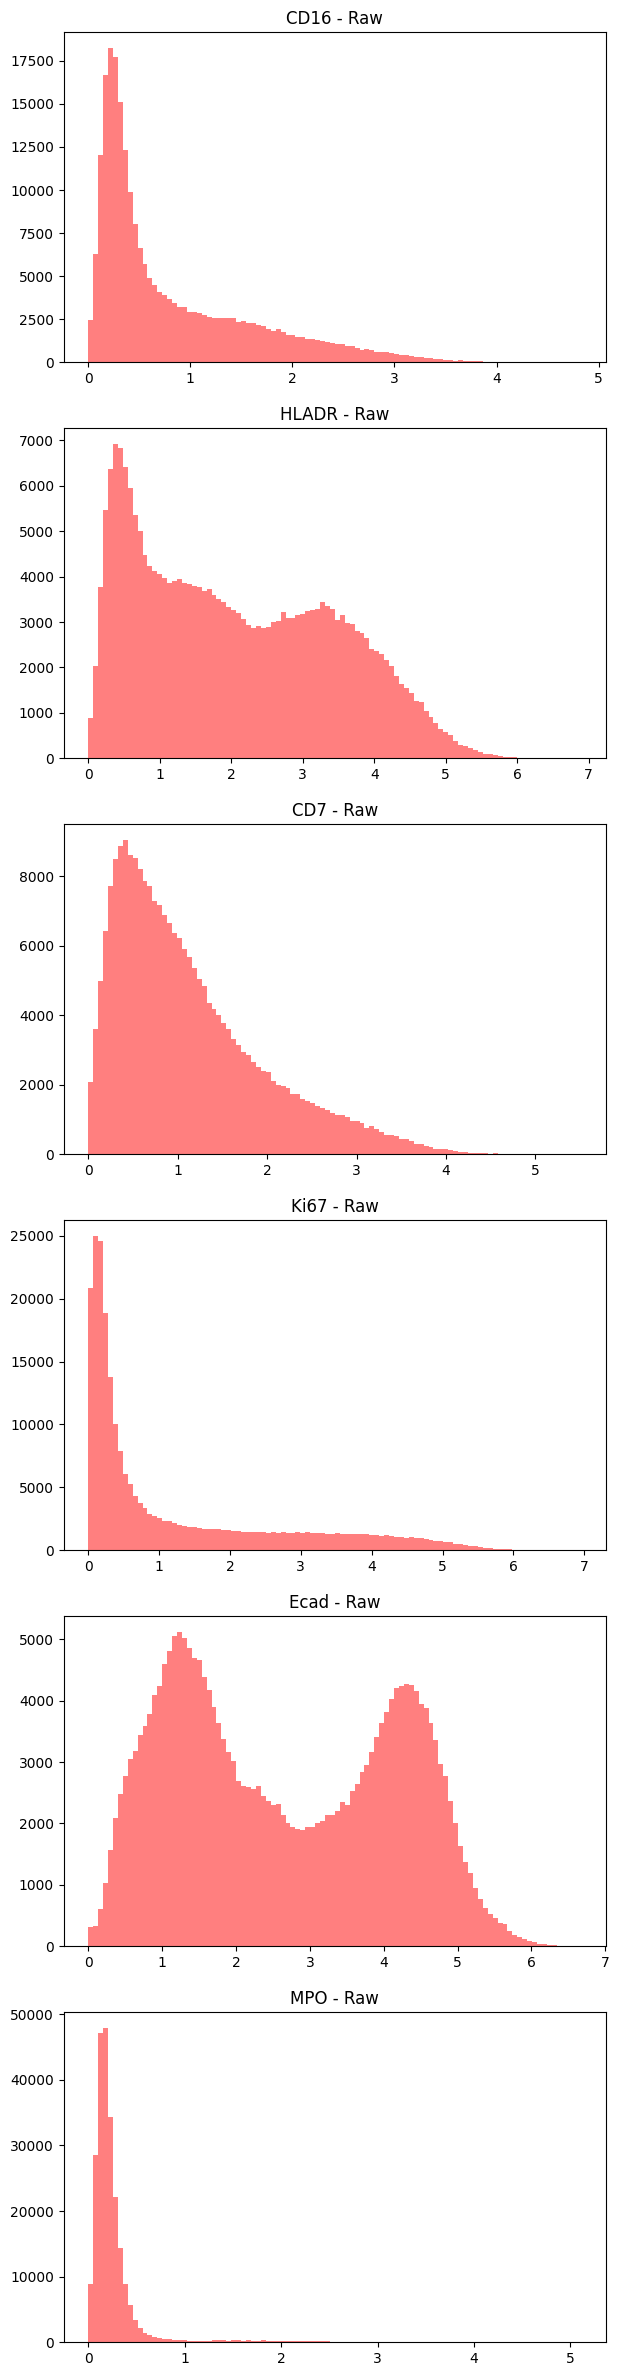

In [13]:
plot_marker_expressions(expressions_df, ['CD16', 'HLADR', 'CD7', 'Ki67', 'Ecad','MPO'])

Some markers display a bimodal distribution, featuring two distinct expression peaks. Others showcase a unimodal distribution with a narrower range of expression values across all cells, or a prominent single peak with the remaining values appearing relatively uniform. Additionally, some markers exhibit a somewhat normal distribution but may be skewed.

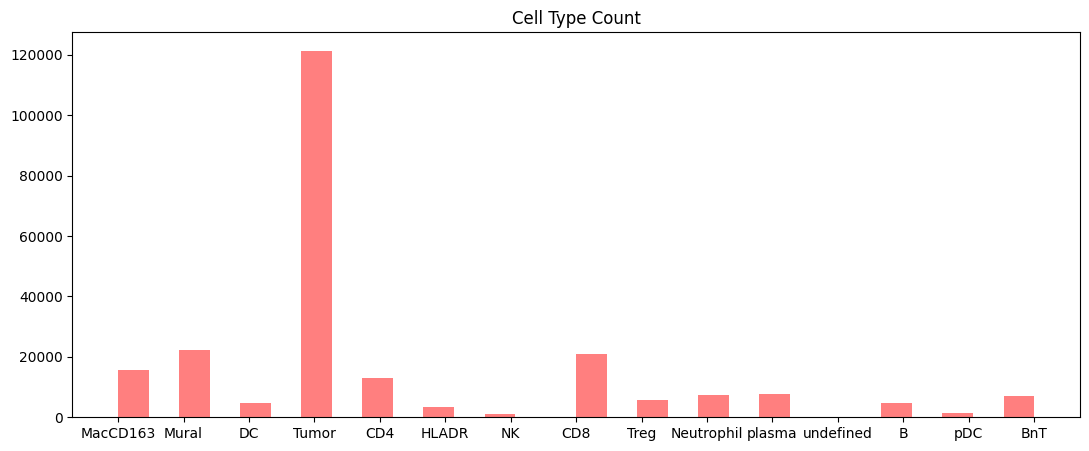

In [14]:
plot_cell_type_count(all_data)

As presented, there is a very significant prevalence of Tumor cells.

Markers exhibit varying levels across different cell types, and we illustrate these discrepancies for a selection of markers.

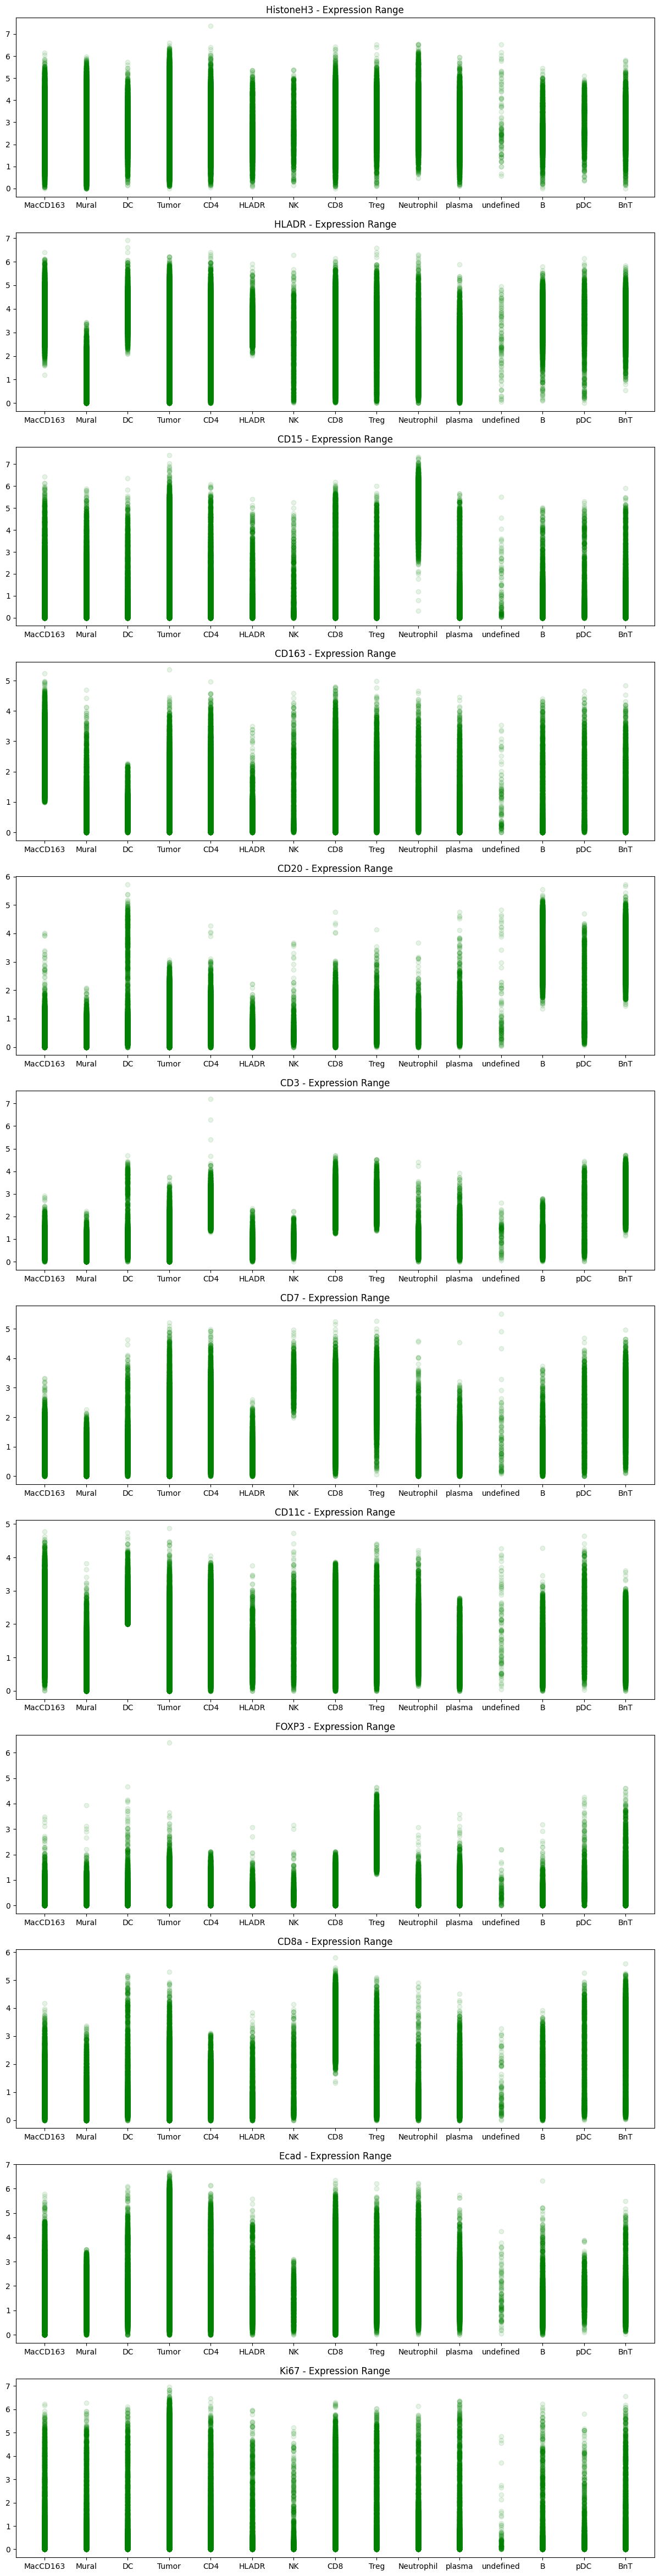

In [15]:
plot_marker_expression_range(all_data, ['HistoneH3', 'HLADR', 'CD15', 'CD163', 'CD20', 'CD3', 'CD7', 'CD11c', 'FOXP3', 'CD8a', 'Ecad', 'Ki67'])

<ipython-input-5-1583d3c73cee>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(exp_df.columns, rotation=90)


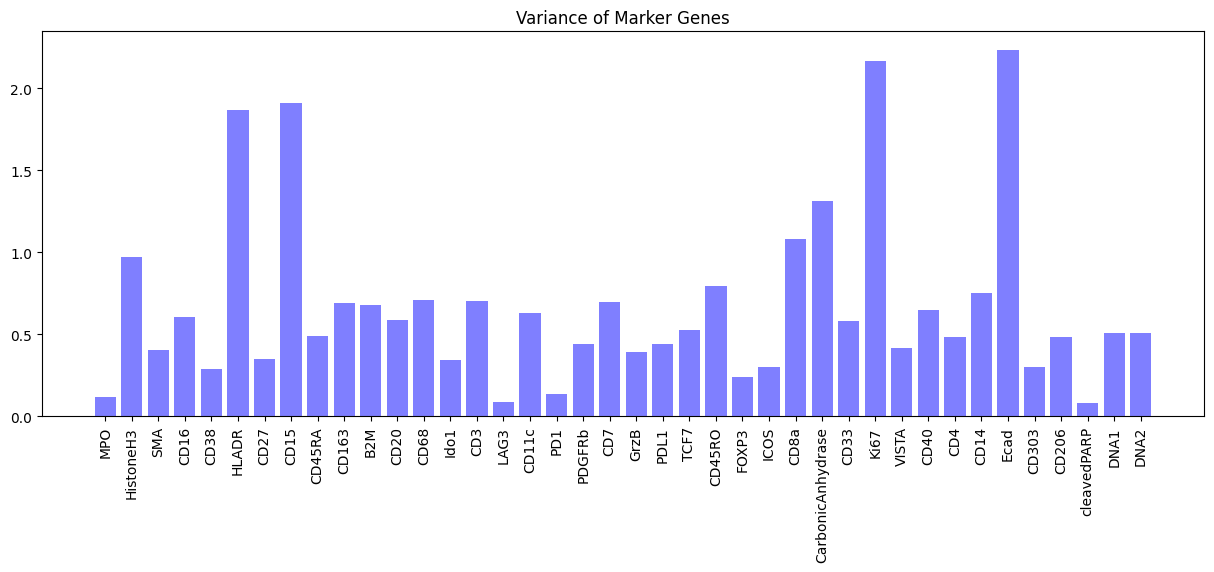

In [16]:
plot_variance_of_markers(expressions_df)

In [17]:
marker_expressions_levels = analyze_marker_expressions(expressions_df, all_data, p_value_threshold=0.01)

In [18]:
significant_markers = get_significant_markers(marker_expressions_levels, all_data, threshold=0.8)

In [19]:
cell_types = all_data['celltypes'].unique()

In [20]:
'. '.join(list(cell_types))

'MacCD163. Mural. DC. Tumor. CD4. HLADR. NK. CD8. Treg. Neutrophil. plasma. undefined. B. pDC. BnT'

In [21]:
significant_markers['Tumor']

{'lower': ['CD163', 'CD16', 'CD68', 'SMA', 'PDGFRb', 'CD45RO'],
 'higher': ['CarbonicAnhydrase', 'Ecad']}

In [22]:
markers_signature_df = make_table_with_significant_markers(significant_markers)

In [23]:
MARKERS_RELATIVE_LEVELS_DF_FILE = 'markers_table.csv'
markers_signature_df = pd.read_csv(MARKERS_RELATIVE_LEVELS_DF_FILE)
markers_signature_df.rename(columns={'Unnamed: 0': 'celltype'}, inplace=True)
markers_signature_df.set_index('celltype', inplace=True)

In [24]:
markers_signature_df.head()

,CD68,CD163,CD14,CD11c,CD206,CD33,CD40,SMA,CD27,CD45RA,...,Ido1,LAG3,PD1,PDGFRb,PDL1,Ki67,cleavedPARP,B2M,CarbonicAnhydrase,VISTA
celltype,,,,,,,,,,,,,,,,,,,,,
B,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.5,1.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
Neutrophil,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
DC,0.0,0.0,0.0,1.0,0.5,0.0,1.0,0.0,0.0,0.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
HLADR,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,...,0.5,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
NK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


## Cell types and markers correlation

Our objective was to examine the markers exhibiting significantly higher or lower levels across all cell types. To achieve this, we conducted T-tests comparing the means of marker levels for a specific cell type against the means of marker levels for the remaining cell types. Additionally, T-tests were performed for each Region of Interest (ROI) individually to ensure that any differences in marker level distributions were not confounded by potential batch effects.

We set the significance threshold at a p-value of 0.01 and identified sets of markers that were significantly higher or lower for each ROI and each cell type. We considered the results reliable if a particular marker showed a significant difference in at least 80% of the ROI.

The results are documented in the 'markers_levels_in_cell_types.csv' file, and we highlight a selection of biologically intriguing findings below.

In [25]:
cell_types_subset = ['Tumor', 'Mural', 'DC', 'MacCD163', 'CD4', 'CD8']
markers_subset = ['HLADR', 'CD8a', 'HistoneH3', 'CD11c', 'CD4', 'PDGFRb', 'Ecad', 'CD3', 'ICOS']
sub_signature_df = markers_signature_df.loc[cell_types_subset, markers_subset]

In [26]:
sub_signature_df

,HLADR,CD8a,HistoneH3,CD11c,CD4,PDGFRb,Ecad,CD3,ICOS
celltype,,,,,,,,,
Tumor,0.0,0.0,1.0,0.0,0.0,0.5,1.0,0.0,0.0
Mural,0.5,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0
DC,1.0,0.0,1.0,1.0,0.0,0.5,0.0,0.0,0.5
MacCD163,1.0,0.0,1.0,1.0,0.5,0.5,0.0,0.0,0.0
CD4,0.5,0.0,1.0,0.0,1.0,0.5,0.0,1.0,0.5
CD8,0.5,1.0,1.0,0.0,0.0,0.5,0.0,1.0,0.0


## Biological explanation
* High expression of Ecan on Tumor cells

* High expression of HLADR on Macrophages and Dendritic cells

* High expression of CD11c on Dendritic cells

* High expression of CD4 in CD4 T cells

* Low expression of Histone H3 in Mural cells

* Low expression of ICOS in Mural cells

* High expression of SMA in Mural cells

* High expression of CD11c on Marcophages and Dentritic cells

* High expression of CD8a on CD8 T cells

* High expression of CD3 on T cells

* High expression of Carbonic Anhydrase in Tumor cells

* High expression of CD68 on Macrophages



## Co-expression of markers

In [27]:
markers_corr = expressions_df.corr()

<Axes: xlabel='marker', ylabel='marker'>

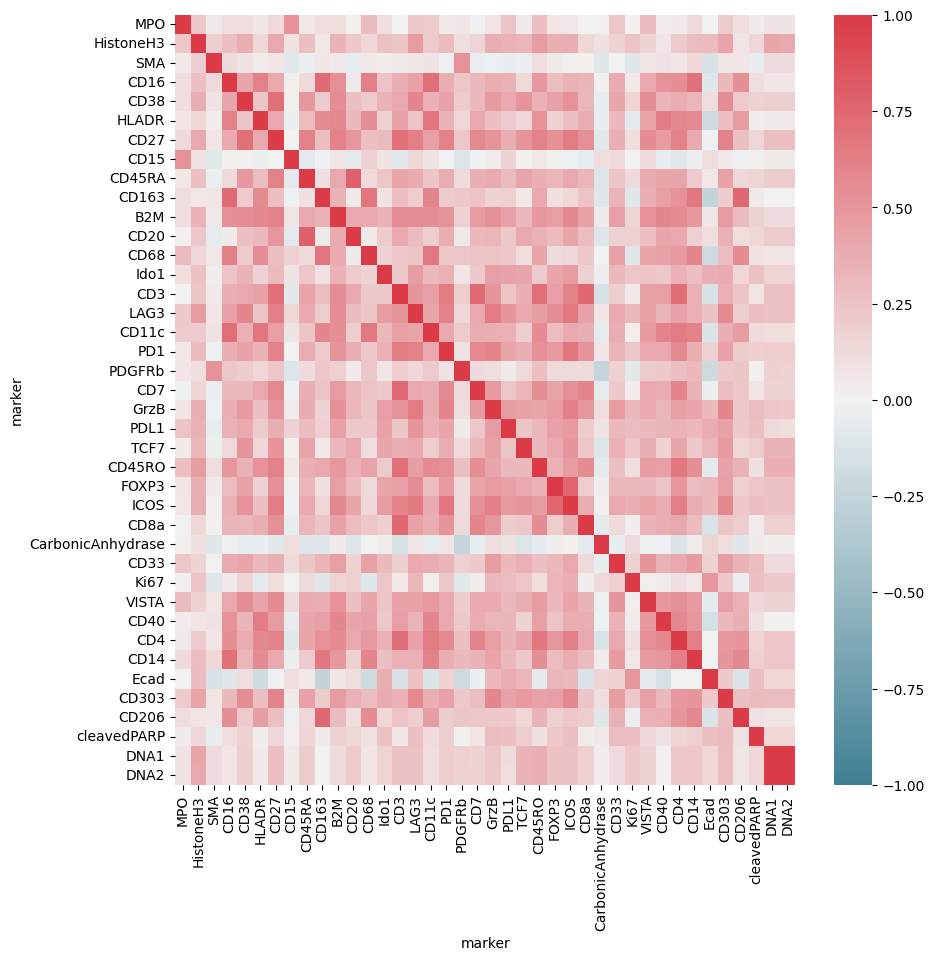

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(markers_corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            xticklabels=markers_corr.columns.values,
            yticklabels=markers_corr.columns.values,
            ax=ax)

In [29]:
from collections import defaultdict
from pathlib import Path
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from typing import List
import joblib

from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

import seaborn as sns
import json

In [30]:
def fit_model(
    preds: pd.DataFrame,
    n_of_tries: int,
    min_n_of_clusters: int,
    max_n_of_clusters: int,
    steps: int,
    take_every_train: int,
    clusterer: KMeans,
):
    k_means_dict = defaultdict(list)

    for nb_of_clusters in tqdm(
        range(min_n_of_clusters, max_n_of_clusters + steps, steps),
        desc="Fitting_models",
    ):
        #         print(nb_of_clusters)
        current_k_means = KMeans(n_clusters=nb_of_clusters)
        k_means_dict[nb_of_clusters].append(
            current_k_means.fit(preds[::take_every_train])
        )

    return k_means_dict

In [35]:
tumor_data = all_data[all_data['celltypes'] == 'Tumor']

In [36]:
tumor_data.columns

Index(['index', 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area',
       'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px',
       'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description',
       'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI',
       'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI',
       'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes',
       'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos',
       'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels',
       'MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
       'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
       'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
       'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
       'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
       'DNA

In [37]:
all_data['celltypes']

0         MacCD163
1            Mural
2               DC
3            Tumor
4            Tumor
            ...   
236786       Mural
236787       Mural
236788         CD8
236789       Mural
236790       Tumor
Name: celltypes, Length: 236791, dtype: category
Categories (15, object): ['B', 'BnT', 'CD4', 'CD8', ..., 'Tumor', 'pDC', 'plasma', 'undefined']

In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Wybierz kolumny z ekspresją genów
expression_columns = ['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
                      'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
                      'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
                      'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
                      'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
                      'DNA2']

# Wybierz tylko te kolumny z DataFrame 'all_data'
expression_data = all_data[expression_columns]

# Standaryzacja danych
scaler = StandardScaler()
expression_data_scaled = scaler.fit_transform(expression_data)

# Przeprowadź klastrowanie K-means
kmeans = KMeans(n_clusters=, random_state=42)
clusters = kmeans.fit_predict(expression_data_scaled)

# Dodaj kolumnę 'cluster' do DataFrame 'all_data' z przypisanymi klastrami
all_data['cluster'] = clusters


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [34]:
all_data['cluster']

0         2
1         0
2         2
3         2
4         0
         ..
236786    2
236787    0
236788    2
236789    0
236790    2
Name: cluster, Length: 236791, dtype: int32

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Zdefiniuj zakres liczby klastrów do przetestowania
min_clusters = 2
max_clusters = 10

# Przeprowadź iterację dla różnych liczności klastrów
best_dbi = float('inf')
best_clusters = None

for n_clusters in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(expression_data_scaled)
    print(clusters)
    dbi = davies_bouldin_score(expression_data_scaled, clusters)

    # Sprawdź, czy DBI dla bieżącej liczby klastrów jest lepszy niż poprzednio najlepszy
    if dbi < best_dbi:
        best_dbi = dbi
        best_clusters = clusters
        n = n_clusters

# Po zakończeniu iteracji wybierz optymalną liczbę klastrów i wykonaj klastrowanie K-means dla tej liczby klastrów
print("Najlepsza liczba klastrów:", best_clusters, n)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 0 ... 0 1 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2 0 2 ... 2 0 2]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2 0 2 ... 2 0 3]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 4 1 ... 1 4 2]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2 1 2 ... 2 1 5]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[5 0 5 ... 5 2 1]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[4 7 4 ... 4 7 1]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[7 0 7 ... 8 0 6]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[9 0 9 ... 5 0 7]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[7 8 7 ... 2 8 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 2 11  2 ...  3 11  3]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 8 11  8 ...  4 11  4]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[10  9 10 ... 12  9 12]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 2 10  2 ... 14 10  6]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 9 12  9 ...  2 12 10]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 7 15  7 ...  5 15  5]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[11 14 11 ...  6  1 14]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 3 0 ... 0 3 8]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 4 1 ... 7 4 0]
Najlepsza liczba klastrów: [1 1 0 ... 0 1 0] 2


In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Redukcja wymiarowości danych za pomocą t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(expression_data_scaled)

# Wykres punktowy z klastrami
plt.figure(figsize=(10, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=clusters, cmap='viridis')
plt.title('K-means Clustering with t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster')
plt.show()


KeyboardInterrupt: 

In [41]:
from collections import defaultdict

from sklearn.cluster import KMeans


k_means_dict = defaultdict(list)


MIN_NB_OF_CLUSTERS = 2
MAX_NB_OF_CLUSTERS = 10
STEPS = 1
NUMBER_OF_TRIES = 3

for nb_of_clusters in range(MIN_NB_OF_CLUSTERS, MAX_NB_OF_CLUSTERS + STEPS, STEPS):
    print(nb_of_clusters)
    for nb_of_try in range(NUMBER_OF_TRIES):
        current_k_means = KMeans(n_clusters=nb_of_clusters)
        k_means_dict[nb_of_clusters].append(
            current_k_means.fit(tumor_data)
        )

2


ValueError: could not convert string to float: 'IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_7'

In [53]:
tumor_data[numerical_columns]

,MPO,HistoneH3,SMA,CD16,CD38,HLADR,CD27,CD15,CD45RA,CD163,...,VISTA,CD40,CD4,CD14,Ecad,CD303,CD206,cleavedPARP,DNA1,DNA2
3,0.165905,1.144778,0.563216,1.166010,0.513735,2.034705,0.650242,0.250150,1.205007,0.990385,...,1.866916,1.228290,2.287524,2.491710,2.268924,0.196199,0.946492,0.233095,3.736089,4.368012
4,0.137497,2.210970,0.892371,0.497646,0.412840,1.499184,0.098131,0.208566,0.922874,1.255892,...,0.806346,0.360098,1.445085,2.332546,2.387292,0.061568,1.632904,0.372278,4.607359,5.152041
5,0.130002,0.763070,0.084880,0.578651,0.249627,1.608196,0.381839,0.017021,0.333893,0.376040,...,0.935827,0.683463,1.073085,2.031410,3.025615,0.000000,0.457221,0.147918,4.625445,5.103166
23,0.052607,1.732363,0.852566,0.356531,0.170076,0.610323,0.236015,0.114076,0.195641,0.270131,...,0.345455,0.320973,1.287706,1.078456,2.332815,0.000000,0.625975,0.072787,4.277741,4.800671
55,0.000000,0.881374,0.620422,0.668122,0.469823,0.171332,0.104139,0.000000,1.067393,0.442563,...,0.123265,0.363477,0.941620,0.912366,2.256495,0.228603,0.528715,0.094815,3.451175,4.061275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236777,0.310763,5.662029,0.000000,1.930384,1.266517,2.416677,1.454401,1.793315,1.153145,0.268418,...,0.497431,0.184777,0.576694,3.153904,3.747758,1.430592,0.300683,0.207754,4.082279,4.659309
236779,0.353124,6.343937,1.443070,2.764597,1.619617,2.128053,2.348564,1.730879,2.224251,1.011342,...,0.395083,0.168831,0.480288,2.089919,2.824779,1.327658,0.461557,0.342643,4.902707,5.419496
236780,0.516624,6.012589,1.134813,2.510355,1.547129,2.410669,1.999906,1.927906,1.809402,0.525357,...,0.468912,0.284126,1.046731,3.186178,3.962100,1.717256,0.317419,0.434471,4.541152,5.038857
236781,0.330040,6.170305,0.768679,2.526116,1.538002,2.536107,2.275608,1.753355,1.771835,0.943245,...,0.456508,0.300978,0.630578,3.101693,3.455742,1.647178,0.604681,0.201348,4.715174,5.193473


In [42]:
from sklearn.cluster import KMeans

# Wybierz tylko kolumny z danymi numerycznymi
numerical_columns = ['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
                     'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
                     'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
                     'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
                     'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
                     'DNA2']

numerical_data = tumor_data[numerical_columns]

# Przeprowadź iterację dla różnych liczności klastrów
k_means_dict = defaultdict(list)
MIN_NB_OF_CLUSTERS = 2
MAX_NB_OF_CLUSTERS = 10
STEPS = 1
NUMBER_OF_TRIES = 3

for nb_of_clusters in range(MIN_NB_OF_CLUSTERS, MAX_NB_OF_CLUSTERS + STEPS, STEPS):
    for nb_of_try in range(NUMBER_OF_TRIES):
        current_k_means = KMeans(n_clusters=nb_of_clusters)
        k_means_dict[nb_of_clusters].append(
            current_k_means.fit(numerical_data)
        )


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [43]:
k_means_dict

defaultdict(list,
            {2: [KMeans(n_clusters=2),
              KMeans(n_clusters=2),
              KMeans(n_clusters=2)],
             3: [KMeans(n_clusters=3),
              KMeans(n_clusters=3),
              KMeans(n_clusters=3)],
             4: [KMeans(n_clusters=4),
              KMeans(n_clusters=4),
              KMeans(n_clusters=4)],
             5: [KMeans(n_clusters=5),
              KMeans(n_clusters=5),
              KMeans(n_clusters=5)],
             6: [KMeans(n_clusters=6),
              KMeans(n_clusters=6),
              KMeans(n_clusters=6)],
             7: [KMeans(n_clusters=7),
              KMeans(n_clusters=7),
              KMeans(n_clusters=7)],
             8: [KMeans(), KMeans(), KMeans()],
             9: [KMeans(n_clusters=9),
              KMeans(n_clusters=9),
              KMeans(n_clusters=9)],
             10: [KMeans(n_clusters=10),
              KMeans(n_clusters=10),
              KMeans(n_clusters=10)]})

In [44]:
cluster_nbs, inertias = [], []

for nb_of_clusters, k_means_clusterers in k_means_dict.items():
    for k_means_clusterer in k_means_clusterers:
        cluster_nbs.append(nb_of_clusters)
        inertias.append(k_means_clusterer.inertia_)

In [45]:
inertias

[1873692.2609310548,
 1873692.876961838,
 1873694.5399824472,
 1676051.9451376372,
 1676052.687580753,
 1676052.6475728827,
 1547687.3565618899,
 1547685.3018079367,
 1547687.3565618899,
 1434008.4521304108,
 1434008.7772565023,
 1434008.5212632078,
 1369227.5938250818,
 1369228.3806751424,
 1369226.3431789433,
 1316444.8304758994,
 1316444.509600335,
 1316443.7800057754,
 1272770.9406617312,
 1272754.0777812242,
 1272781.8962252496,
 1234131.2479539835,
 1234129.324009968,
 1234125.3453621103,
 1203483.5849133632,
 1203500.7110179057,
 1203483.8251092425]

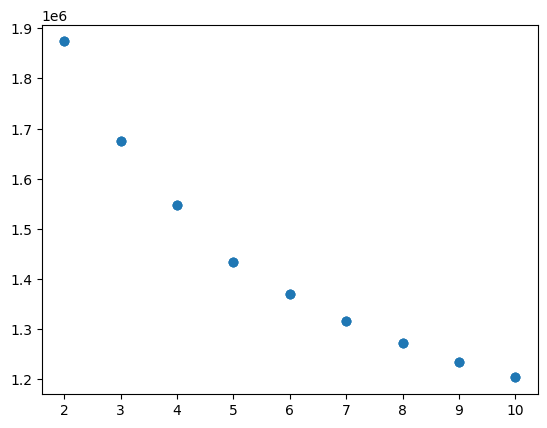

In [46]:
import matplotlib.pyplot as plt


plt.scatter(cluster_nbs, inertias)


In [63]:
from sklearn.metrics import fowlkes_mallows_score

# Lista przechowująca wyniki Fowlkes-Mallows Score
fowlkes_mallows_scores = []

for nb_of_clusters, k_means_clusterers in k_means_dict.items():
    for k_means_clusterer in k_means_clusterers:
        # Przewidywane etykiety klastrów
        predicted_labels = k_means_clusterer.labels_

        # Obliczanie Fowlkes-Mallows Score
        score = fowlkes_mallows_score(tumor_data['cluster'], predicted_labels)
        fowlkes_mallows_scores.append(score)

# Wyświetlenie wyników
print(fowlkes_mallows_scores)


[0.719351537911221, 0.7194608111767837, 0.7191320455271855, 0.6165481081408424, 0.616310795798284, 0.6166844985479001, 0.5259853851355822, 0.5229563165643621, 0.5259853851355822, 0.47265200367190874, 0.47256476722342144, 0.4726309305524627, 0.4516554885983562, 0.4518312678183913, 0.45204630284955, 0.39874225850043615, 0.39791095084347583, 0.3986474365814738, 0.38304555505470445, 0.3837167484108034, 0.38305684949488294, 0.3694041963360576, 0.36992442924816826, 0.3698046831990916, 0.3577357712325615, 0.3553753868331587, 0.3577358408445635]


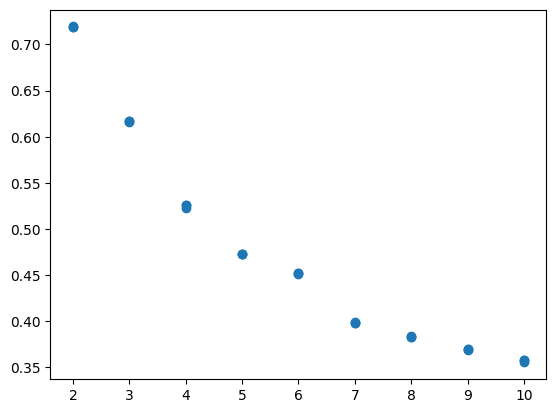

In [48]:
import matplotlib.pyplot as plt


plt.scatter(cluster_nbs, fowlkes_mallows_scores)

In [54]:
predictions_dict = defaultdict(list)


for nb_of_clusters, k_means_clusterers in k_means_dict.items():
    print(nb_of_clusters)
    for k_means_clusterer in k_means_clusterers:
        predictions_dict[nb_of_clusters].append(k_means_clusterer.predict(numerical_data))

2
3
4
5
6
7
8
9
10


In [55]:
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score


SILHOUETTE_TAKE_EVERY = 10

cluster_nbs_fms, fmses = [], []
cluster_nbs_chs, chses = [], []
(
    cluster_nbs_sill,
    sills,
) = (
    [],
    [],
)

for nb_of_clusters, predictions_ in predictions_dict.items():
    print(nb_of_clusters)
    for i in range(NUMBER_OF_TRIES):
        cluster_nbs_chs.append(nb_of_clusters)
        cluster_nbs_sill.append(nb_of_clusters)
        # sills.append(silhouette_score(
        #    preds[::SILHOUETTE_TAKE_EVERY],
        #    predictions_dict[nb_of_clusters][i][::SILHOUETTE_TAKE_EVERY]
        # ))
        # chses.append(calinski_harabasz_score(preds, predictions_dict[nb_of_clusters][i]))
        for j in range(i + 1, NUMBER_OF_TRIES):
            fmses.append(fowlkes_mallows_score(predictions_[i], predictions_[j]))
            cluster_nbs_fms.append(nb_of_clusters)

2
3
4
5
6
7
8
9
10


In [57]:
cluster_nbs = sorted(list(predictions_dict.keys()))

In [58]:
cluster_sizes, fmses = [], []

for start_index in range(1, len(cluster_nbs) - 1):
    print(cluster_nbs[start_index])
    prev_cl_nb = cluster_nbs[start_index - 1]
    curr_cl_nb = cluster_nbs[start_index]
    next_cl_nb = cluster_nbs[start_index + 1]
    for prev_preds, current_preds, next_preds in zip(
        predictions_dict[prev_cl_nb],
        predictions_dict[curr_cl_nb],
        predictions_dict[next_cl_nb],
    ):
        cluster_sizes.append(curr_cl_nb)
        fmses.append(fowlkes_mallows_score(prev_preds, current_preds))
        cluster_sizes.append(curr_cl_nb)
        fmses.append(fowlkes_mallows_score(next_preds, current_preds))

3
4
5
6
7
8
9


In [59]:
cluster_sizes_to_fmses = defaultdict(list)


for cs, fms in zip(cluster_sizes, fmses):
    cluster_sizes_to_fmses[cs].append(fms)

In [60]:
import numpy as np


cluster_sizes_to_fmses_means = {
    cs: np.array(fmses_).mean() for cs, fmses_ in cluster_sizes_to_fmses.items()
}

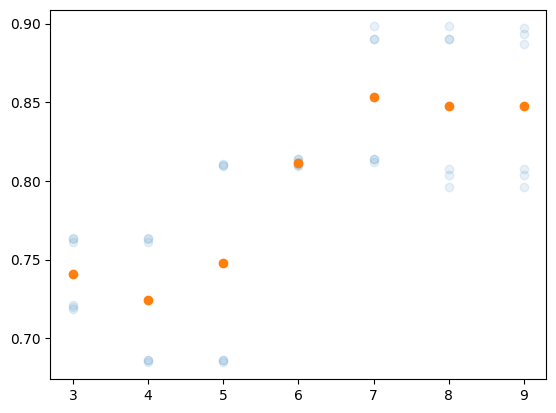

In [61]:
plt.scatter(cluster_sizes, fmses, alpha=0.1)
plt.scatter(cluster_sizes_to_fmses_means.keys(), cluster_sizes_to_fmses_means.values())

In [82]:
# Wybierz k-means z 7 klastrami
k_means_7 = k_means_dict[7][0]  # Wybierz pierwszy k-means z listy dla 7 klastrów

# Przewidywane etykiety klastrów dla 7 klastrów
predicted_labels_7 = k_means_7.labels_

# Przypisz etykiety klastrów do oryginalnego DataFrame za pomocą .loc[]
tumor_data.loc[:, 'clusters'] = predicted_labels_7

# Wyświetl DataFrame z nową kolumną 'clusters'
# print(tumor_data)
tumor_data['image']

3         IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...
4         IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...
5         IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...
23        IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...
55        IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...
                                ...                        
236777        IMMUcan_Batch20220908_S-220729-00002_002.tiff
236779        IMMUcan_Batch20220908_S-220729-00002_002.tiff
236780        IMMUcan_Batch20220908_S-220729-00002_002.tiff
236781        IMMUcan_Batch20220908_S-220729-00002_002.tiff
236790        IMMUcan_Batch20220908_S-220729-00002_002.tiff
Name: image, Length: 121404, dtype: category
Categories (125, object): ['10068190-SPECT-VAR-TIS-01-IMC-01_001.tiff', 'IMMUcan_2022_WFLOW_10034294-GI-VAR-TIS-UNST-0...,
                           'IMMUcan_2022_WFLOW_10061074-SPECT-VAR-TIS-01-..., 'IMMUcan_2022_WFLOW_10063152-SPECT-VAR-TIS-01-...,
                           ..., 'IMMUcan_SP

                                                   index  \
185714     IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff_3   
185715     IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff_4   
185717    IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff_11   
185719    IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff_15   
185720    IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff_18   
...                                                  ...   
187223  IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff_1972   
187224  IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff_1974   
187225  IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff_1975   
187226  IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff_1977   
187227  IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff_1978   

                                              image  \
185714  IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff   
185715  IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff   
185717  IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff   
185719  IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff   
1857

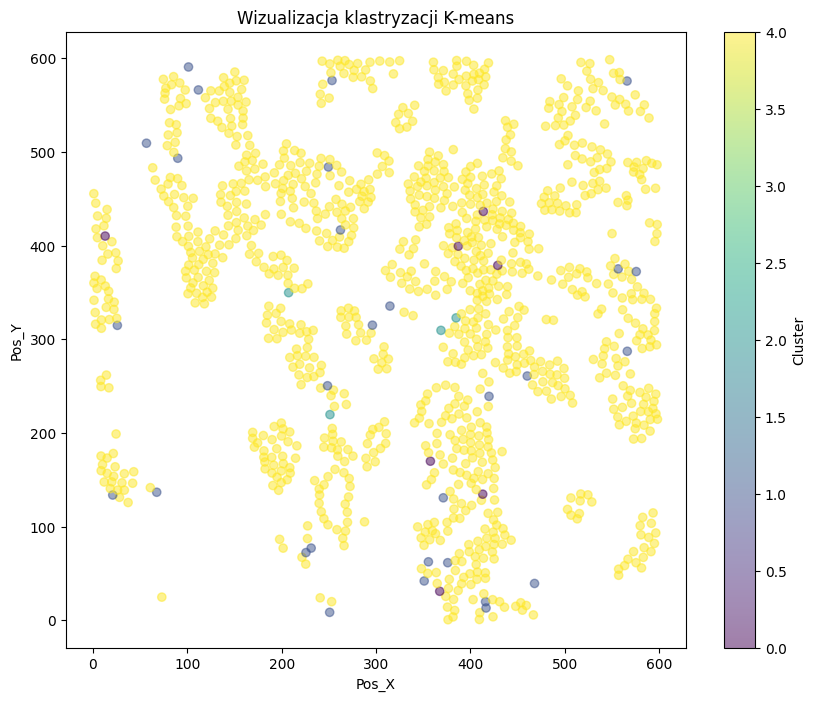

In [84]:
import matplotlib.pyplot as plt

# Wybierz kolumny z pozycją X i Y oraz klastry
# Wybierz tylko wiersze, gdzie wartość kolumny 'image' jest równa 'a'
dane = tumor_data.loc[tumor_data['image'] == 'IMMUcan_SPECTA_LUNG_S-210607-00002_001.tiff']

# Wyświetl nową ramkę danych
print(dane)


positions = dane[['Pos_X', 'Pos_Y']]
clusters = dane['clusters']

# Wygeneruj wykres punktowy
plt.figure(figsize=(10, 8))
plt.scatter(positions['Pos_X'], positions['Pos_Y'], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Wizualizacja klastryzacji K-means')
plt.xlabel('Pos_X')
plt.ylabel('Pos_Y')
plt.colorbar(label='Cluster')
plt.show()


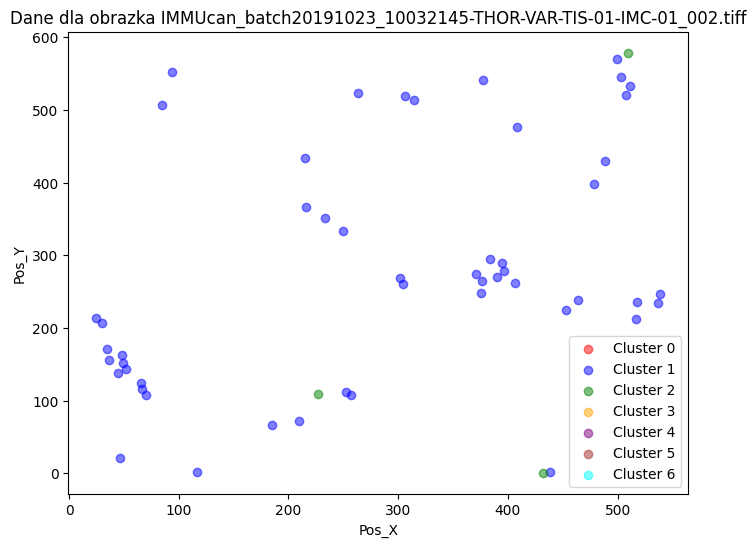

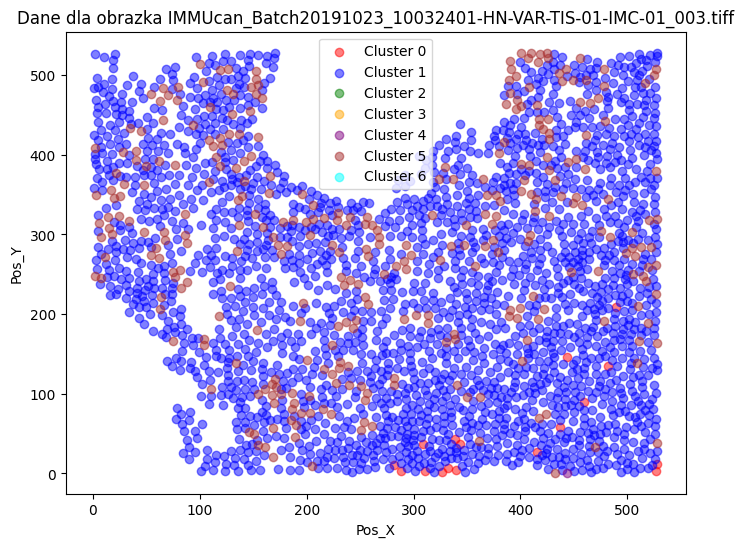

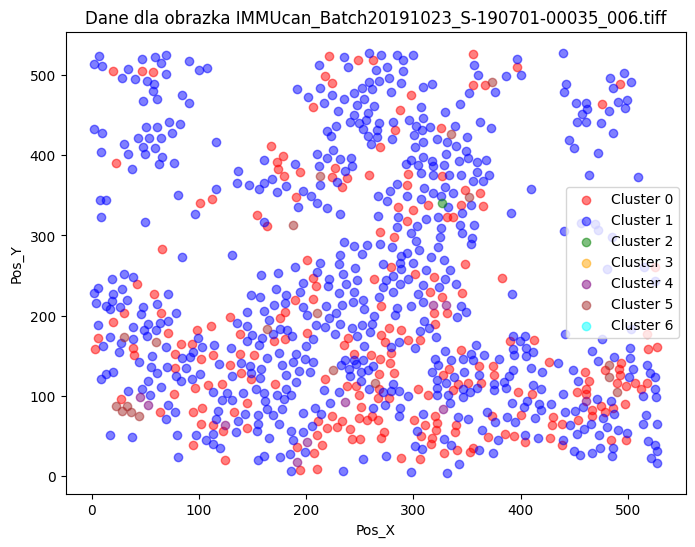

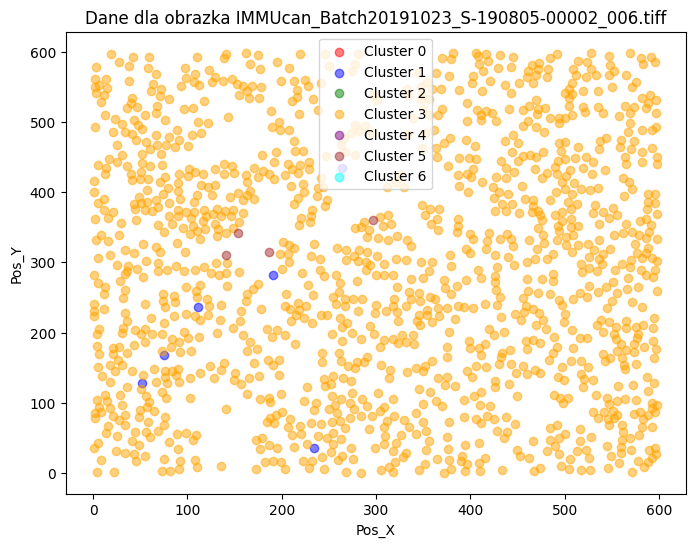

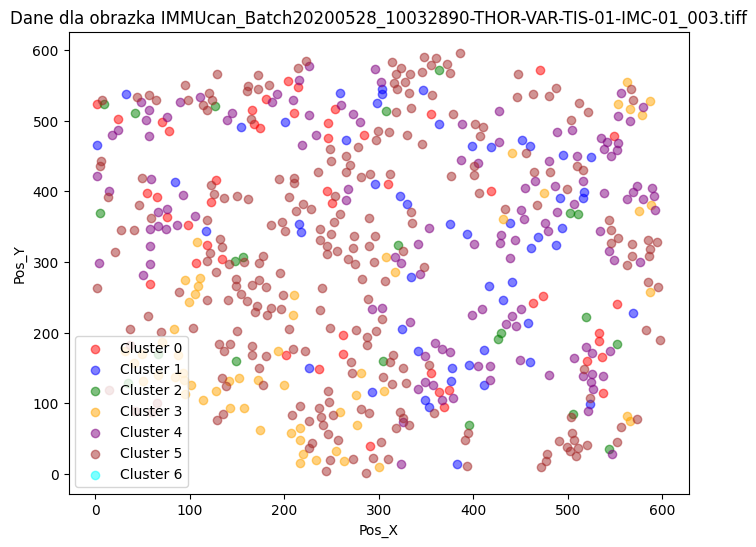

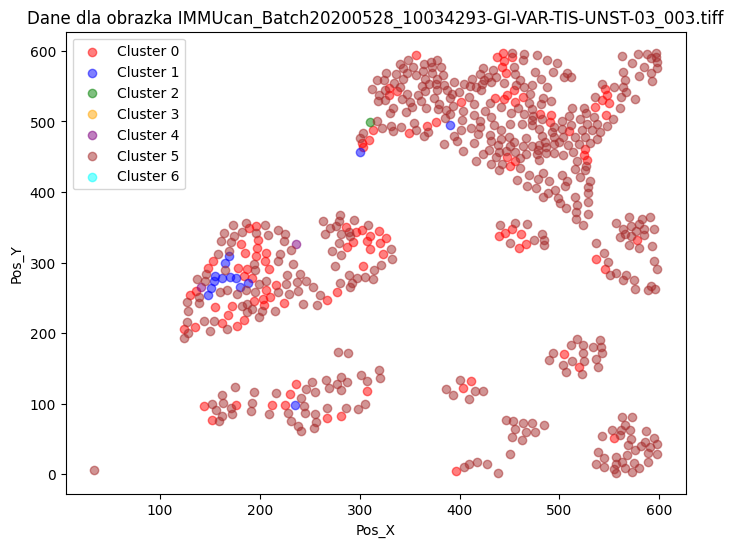

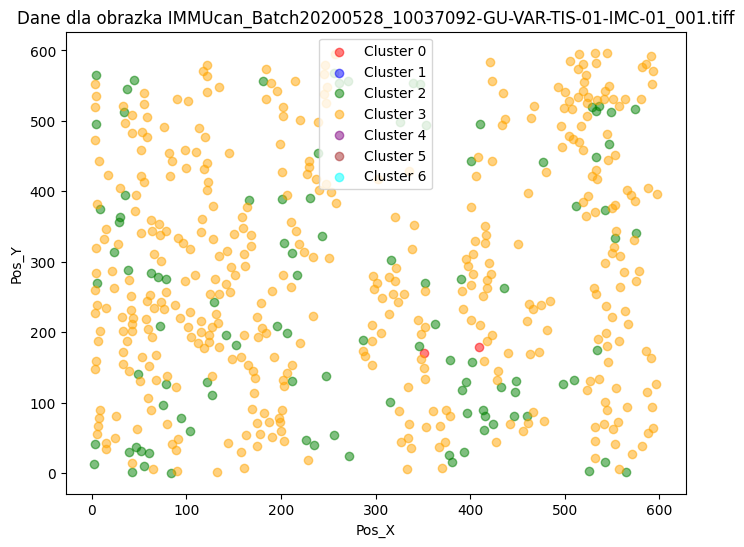

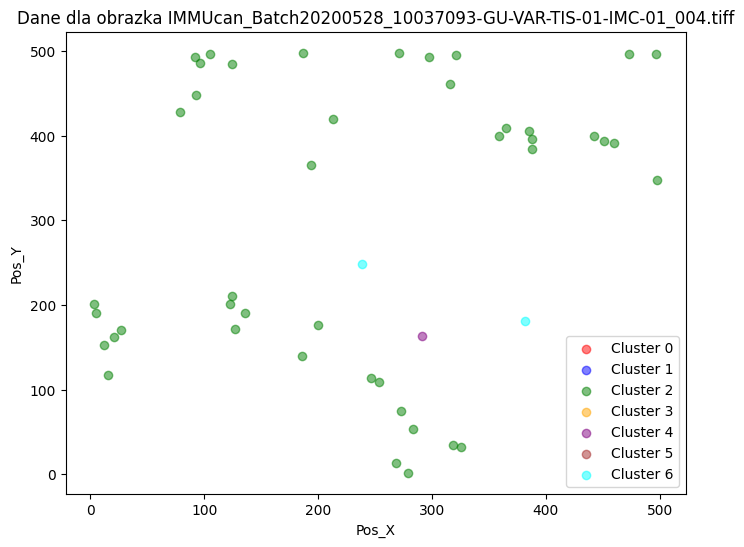

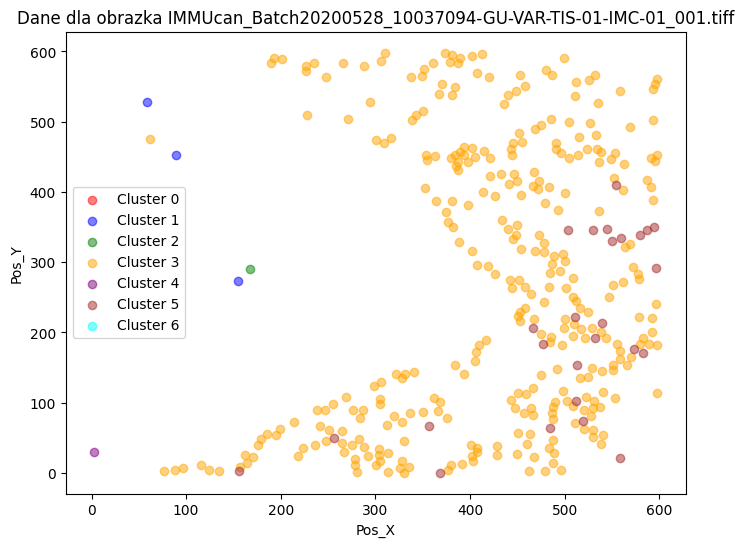

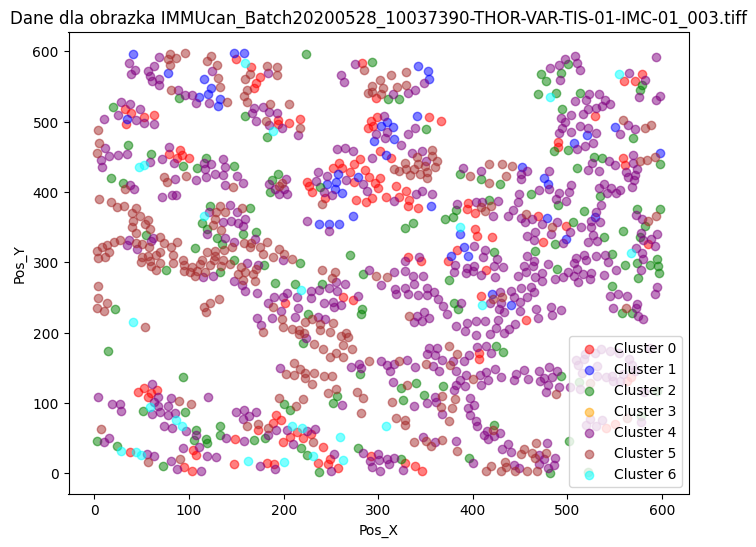

In [88]:
import matplotlib.pyplot as plt

# Definiujemy 7 podstawowych kolorów
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan']

# Wybierz unikalne nazwy obrazów
unique_images = tumor_data['image'].unique()

# Iteruj przez pierwszych 10 unikalnych nazw obrazów
for i, image_name in enumerate(unique_images[:10], 1):
    # Wybierz dane tylko dla danego obrazka
    image_data = tumor_data[tumor_data['image'] == image_name]

    # Wygeneruj nowy wykres
    plt.figure(figsize=(8, 6))
    for cluster, color in zip(range(7), colors):
        cluster_data = image_data[image_data['clusters'] == cluster]
        plt.scatter(cluster_data['Pos_X'], cluster_data['Pos_Y'], c=color, label=f'Cluster {cluster}', alpha=0.5)
    plt.title(f'Dane dla obrazka {image_name}')
    plt.xlabel('Pos_X')
    plt.ylabel('Pos_Y')
    plt.legend()
    plt.show()



In [102]:
from sklearn.mixture import GaussianMixture

# Stwórz nowy DataFrame, usuń kolumny z markerami ekspresji
new_df = tumor_data.drop(['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
                     'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
                     'CD11c', 'PDGFRb', 'CD7', 'GrzB', 'PD1', 'TCF7', 'CD45RO',
                     'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
                     'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
                     'DNA2'], axis=1)

# Wybierz tylko kolumnę PD1
pd1_data = tumor_data[['PDL1']]

# Przeprowadź dopasowanie modelu Gaussian Mixture
gmm = GaussianMixture(n_components=2, random_state=0).fit(pd1_data)

# Przypisz etykiety klastrów do nowej kolumny w nowym DataFrame
new_df['PDL1_label'] = gmm.predict(pd1_data)

# Zamień etykiety klastrów na 0 i 1
new_df['PDL1_label'] = new_df['PDL1_label'].replace({0: 1, 1:0})

# Wyświetl nowy DataFrame
print(new_df)


                                                    index  \
3       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
4       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
5       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
23      IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
55      IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
...                                                   ...   
236777  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   
236779  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   
236780  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   
236781  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   
236790  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   

                                                    image  \
3       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
4       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
5       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
23      IMMUcan_batch20

array([0, 1, 1, ..., 0, 1, 1])

<Axes: xlabel='PDL1', ylabel='Count'>

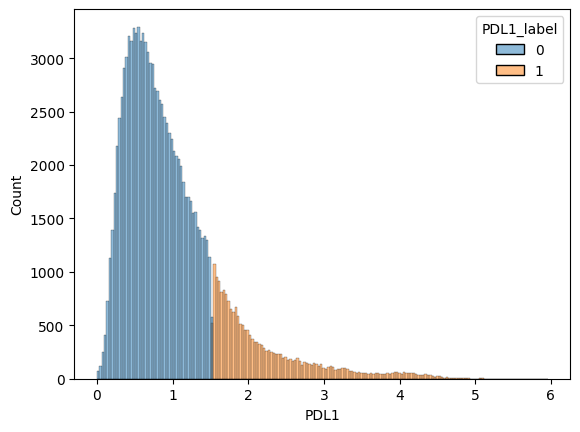

In [103]:
sns.histplot(data=new_df, x="PDL1", hue="PDL1_label")

In [104]:
mac_data = all_data[all_data['celltypes'] == 'MacCD163']

In [105]:
from sklearn.mixture import GaussianMixture

# Stwórz nowy DataFrame, usuń kolumny z markerami ekspresji
new_df = tumor_data.drop(['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
                     'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
                     'CD11c', 'PDGFRb', 'CD7', 'GrzB', 'PD1', 'PDL1', 'TCF7', 'CD45RO',
                     'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
                     'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'cleavedPARP', 'DNA1',
                     'DNA2'], axis=1)

# Wybierz tylko kolumnę PD1
cd_data = tumor_data[['CD206']]

# Przeprowadź dopasowanie modelu Gaussian Mixture
gmm = GaussianMixture(n_components=2, random_state=0).fit(cd_data)

# Przypisz etykiety klastrów do nowej kolumny w nowym DataFrame
new_df['CD206_label'] = gmm.predict(cd_data)

# Zamień etykiety klastrów na 0 i 1
new_df['CD206_label'] = new_df['CD206_label'].replace({0: 1, 1:0})

# Wyświetl nowy DataFrame
print(new_df)

                                                    index  \
3       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
4       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
5       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
23      IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
55      IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
...                                                   ...   
236777  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   
236779  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   
236780  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   
236781  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   
236790  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   

                                                    image  \
3       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
4       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
5       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
23      IMMUcan_batch20

<Axes: xlabel='CD206', ylabel='Count'>

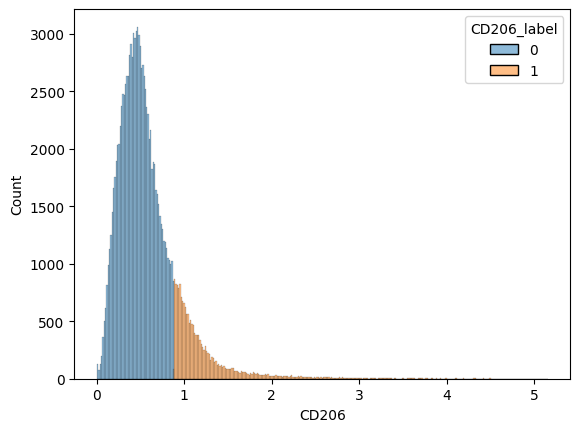

In [106]:
sns.histplot(data=new_df, x="CD206", hue="CD206_label")